<a href="https://colab.research.google.com/github/MuhammadHameed-2943/MuhammadHameed-2943/blob/main/number_guessing_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Define the directories where the models and data will be stored
MODEL_DIR = '/content/drive/MyDrive/number_guessing_game/models'
DATA_DIR = '/content/drive/MyDrive/number_guessing_game/data'

# Ensure the directories exist
import os
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

# Generate synthetic data for the game
def generate_synthetic_data(num_samples=1000):
    data = []
    for i in range(num_samples):
        round_num = i + 1
        guess = np.random.randint(1, 101)  # Random guess
        target = np.random.randint(1, 101)  # Random target number

        # Determine feedback (low, high, correct)
        feedback = 'low' if guess < target else 'high' if guess > target else 'correct'

        data.append([round_num, guess, target, feedback])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['round_num', 'guess', 'target', 'feedback'])

    # Save to Google Drive
    data_path = os.path.join(DATA_DIR, 'synthetic_data.csv')
    df.to_csv(data_path, index=False)
    print(f"Data saved to {data_path}")

    return df

# Generate and save the synthetic data
df = generate_synthetic_data(1000)

Data saved to /content/drive/MyDrive/number_guessing_game/data/synthetic_data.csv


In [3]:
def preprocess_data(df):
    # Convert feedback to numerical values
    df['feedback'] = df['feedback'].map({'low': -1, 'high': 1, 'correct': 0})

    # Create new features: guess difference and trend
    df['guess_diff'] = df['guess'].diff().fillna(0)  # Difference from previous guess
    df['guess_trend'] = np.where(df['guess_diff'] > 0, 1, np.where(df['guess_diff'] < 0, -1, 0))  # Trend

    return df

# Preprocess the data
df = preprocess_data(df)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

def train_random_forest(df):
    # Feature selection
    X = df[['round_num', 'guess', 'feedback', 'guess_diff', 'guess_trend']]  # Features
    y = df['target']  # Target: the actual number to be guessed

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best Model: {best_model}")

    # Model Evaluation
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Optimized Mean Squared Error: {mse}")

    # Save the model to Google Drive
    model_path = os.path.join(MODEL_DIR, 'random_forest_model.pkl')
    joblib.dump(best_model, model_path)
    print(f"Model saved to {model_path}")

    return best_model

# Train the model and save it
best_model = train_random_forest(df)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Model: RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)
Optimized Mean Squared Error: 440.1045928598747
Model saved to /content/drive/MyDrive/number_guessing_game/models/random_forest_model.pkl


In [5]:
import joblib

# Load the trained model from Google Drive
model_path = '/content/drive/MyDrive/number_guessing_game/models/random_forest_model.pkl'
best_model = joblib.load(model_path)
print("Model loaded successfully!")

# Now you can use `best_model` to make predictions in the game
# For example, using the `predict_next_guess` function that was created earlier:
# predict_next_guess(best_model, guess_history, feedback_history)

Model loaded successfully!


In [7]:
def preprocess_data(df):
    # Map the 'feedback' column from categorical (high/low/correct) to numerical (-1, 1, 0)
    df['feedback'] = df['feedback'].map({'low': -1, 'high': 1, 'correct': 0})

    # Create new features: guess difference and trend
    df['guess_diff'] = df['guess'].diff().fillna(0)  # Difference from previous guess
    df['guess_trend'] = np.where(df['guess_diff'] > 0, 1, np.where(df['guess_diff'] < 0, -1, 0))  # Trend

    return df

# Preprocess the data (ensure feedback is numeric)
df = preprocess_data(df)

In [9]:
def predict_next_guess(model, guess_history, feedback_history):
    # Create the features for prediction
    round_num = len(guess_history) + 1  # Guess attempt
    guess = guess_history[-1]  # Last guess
    feedback = feedback_history[-1] if feedback_history else 0  # Default to 0 if no feedback yet

    # Calculate guess_diff (difference from previous guess) and guess_trend
    guess_diff = guess - (guess_history[-2] if len(guess_history) > 1 else 0)
    guess_trend = 1 if guess_diff > 0 else -1 if guess_diff < 0 else 0

    # Prepare the feature vector
    X_new = np.array([[round_num, guess, feedback, guess_diff, guess_trend]])  # Ensure 5 features

    # Predict the next guess
    predicted_guess = model.predict(X_new)[0]
    print(f"AI Prediction: Your next guess could be around {int(predicted_guess)}.")

    return predicted_guess

In [11]:
def predict_next_guess(model, guess_history, feedback_history):
    # Create the features for prediction
    round_num = len(guess_history) + 1  # Guess attempt
    guess = guess_history[-1]  # Last guess
    feedback = feedback_history[-1] if feedback_history else 0  # Default to 0 if no feedback yet

    # Calculate guess_diff (difference from previous guess) and guess_trend
    guess_diff = guess - (guess_history[-2] if len(guess_history) > 1 else 0)
    guess_trend = 1 if guess_diff > 0 else -1 if guess_diff < 0 else 0

    # Prepare the feature vector as a DataFrame
    X_new = pd.DataFrame([[round_num, guess, feedback, guess_diff, guess_trend]],
                         columns=['round_num', 'guess', 'feedback', 'guess_diff', 'guess_trend'])

    # Predict the next guess
    predicted_guess = model.predict(X_new)[0]
    print(f"AI Prediction: Your next guess could be around {int(predicted_guess)}.")

    return predicted_guess

In [13]:
# Generate more synthetic data (e.g., 5000 samples)
df = generate_synthetic_data(5000)
df = preprocess_data(df)  # Ensure feedback is numeric
best_model = train_random_forest(df)

Data saved to /content/drive/MyDrive/number_guessing_game/data/synthetic_data.csv
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Model: RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)
Optimized Mean Squared Error: 414.0305526282588
Model saved to /content/drive/MyDrive/number_guessing_game/models/random_forest_model.pkl


In [15]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df[['round_num', 'guess', 'feedback', 'guess_diff', 'guess_trend']]  # Features
y = df['target']  # Target: the actual number to be guessed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']  # Experiment with different feature counts
}

# Run GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model after GridSearchCV
best_model = grid_search.best_estimator_

# Print the best model and evaluate it
print(f"Best Model: {best_model}")

# Predict and evaluate on the test data
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Optimized Mean Squared Error: {mse}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py"

Best Model: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      n_estimators=300, random_state=42)
Optimized Mean Squared Error: 406.9690303382628


In [16]:
import joblib
from sklearn.metrics import mean_squared_error
import pandas as pd

# Load the trained model
model_path = '/content/drive/MyDrive/number_guessing_game/models/random_forest_model.pkl'
best_model = joblib.load(model_path)
print("Model loaded successfully!")

# Load or generate test data (ensure it's preprocessed)
# Here we're using the same synthetic data that was generated for training
df_test = generate_synthetic_data(500)  # Test data
df_test = preprocess_data(df_test)  # Preprocess it to ensure it's ready for prediction

# Define features (X_test) and target (y_test) for the test data
X_test = df_test[['round_num', 'guess', 'feedback', 'guess_diff', 'guess_trend']]
y_test = df_test['target']

# Predict the target (actual number to be guessed) using the trained model
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test data: {mse}")

Model loaded successfully!
Data saved to /content/drive/MyDrive/number_guessing_game/data/synthetic_data.csv
Mean Squared Error on the test data: 420.19590145551854


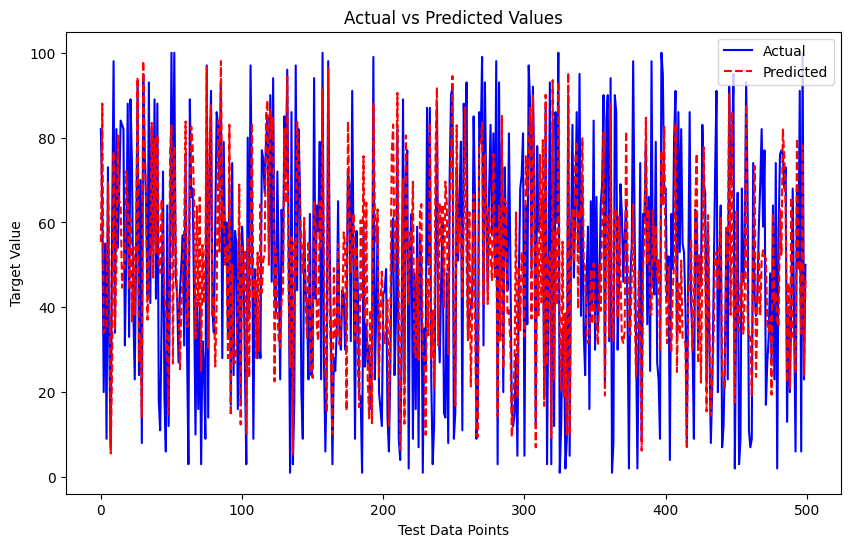

In [17]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Data Points')
plt.ylabel('Target Value')
plt.show()

In [18]:
import joblib

# Load the trained model
model_path = '/content/drive/MyDrive/number_guessing_game/models/random_forest_model.pkl'
best_model = joblib.load(model_path)
print("Model loaded successfully!")

def predict_next_guess(model, guess_history, feedback_history):
    round_num = len(guess_history) + 1  # Guess attempt
    guess = guess_history[-1]  # Last guess
    feedback = feedback_history[-1] if feedback_history else 0  # Default to 0 if no feedback yet

    # Calculate guess_diff (difference from previous guess) and guess_trend
    guess_diff = guess - (guess_history[-2] if len(guess_history) > 1 else 0)
    guess_trend = 1 if guess_diff > 0 else -1 if guess_diff < 0 else 0

    # Prepare the feature vector as a DataFrame
    X_new = pd.DataFrame([[round_num, guess, feedback, guess_diff, guess_trend]],
                         columns=['round_num', 'guess', 'feedback', 'guess_diff', 'guess_trend'])

    # Predict the next guess
    predicted_guess = model.predict(X_new)[0]
    print(f"AI Prediction: Your next guess could be around {int(predicted_guess)}.")

    return predicted_guess

def play_game(model):
    print("Welcome to the Number Guessing Game!")
    target = np.random.randint(1, 101)  # The target number
    guess_history = []  # To store the guesses
    feedback_history = []  # To store the feedback
    attempt = 0

    while True:
        guess = int(input(f"Guess the number (between 1 and 100): "))
        guess_history.append(guess)

        # Determine feedback based on guess and target
        if guess < target:
            feedback = -1  # low
            print("Too low!")
        elif guess > target:
            feedback = 1  # high
            print("Too high!")
        else:
            feedback = 0  # correct
            print(f"Correct! You've guessed the number in {attempt} attempts.")
            break

        feedback_history.append(feedback)

        # Start making predictions after the first attempt
        if attempt > 1:
            predict_next_guess(model, guess_history, feedback_history)

        attempt += 1

# Example usage:
play_game(best_model)  # Play the game with the trained model

Model loaded successfully!
Welcome to the Number Guessing Game!
Guess the number (between 1 and 100): 20
Too high!
Guess the number (between 1 and 100): 83
Too high!
Guess the number (between 1 and 100): 10
Too high!
AI Prediction: Your next guess could be around 4.
Guess the number (between 1 and 100): 90
Too high!
AI Prediction: Your next guess could be around 40.
Guess the number (between 1 and 100): 20
Too high!
AI Prediction: Your next guess could be around 8.
Guess the number (between 1 and 100): 1
Too low!
AI Prediction: Your next guess could be around 52.
Guess the number (between 1 and 100): 2
Too low!
AI Prediction: Your next guess could be around 54.
Guess the number (between 1 and 100): 3
Too low!
AI Prediction: Your next guess could be around 58.
Guess the number (between 1 and 100): 4
Too low!
AI Prediction: Your next guess could be around 57.


KeyboardInterrupt: Interrupted by user